In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Вычисление сумм

В статистике часто приходится считать выборочное среднее, т.е. по данной выборке значений $x_k$, $k=1..N$, нужно вычислить
$$\bar x=\frac1N\sum_{k=1}^N x_k.$$
С точки зрения математики не имеет значения, как считать указанную сумму, так как результат сложения всегда будет один и тот же.
Однако при вычислениях с плавающей запятой ответ будет зависеть от порядка выполнения операций, хотя бы потому, что сложения чисел с плавающей запятой не ассоциативно.
Но будет ли зависеть точность вычислений от порядка операций?
Давайте это проверим.

Сконструируем выборку таким образом, что сумма всех элементов равна $1$, и порядок элементов меняется в широком диапазоне.
Для этого разобьем единицу на $K$ частей, и $k$-ую часть разобьем на $7^k$ равных значений.
Полученные элементы перемешаем.

In [17]:
base=10 # параметр, может принимать любые целые значения > 1

def exact_sum(K):
    """Точное значение суммы всех элементов."""
    return 1.

def samples(K):
    """"Элементы выборки"."""
    # создаем K частей из base^k одинаковых значений
    parts=[np.full((base**k,), float(base)**(-k)/K) for k in range(0, K)] 
    # создаем выборку объединяя части
    samples=np.concatenate(parts) 
    # перемешиваем элементы выборки и возвращаем
    return np.random.permutation(samples)

def direct_sum(x):
    """Последовательная сумма всех элементов вектора x"""
    s=0.
    for e in x: 
        s+=e
    return s

In [18]:
def number_of_samples(K):
    """Число элементов в выборке"""
    return np.sum([base**k for k in range(0, K)])

def exact_mean(K):
    """Значение среднего арифметического по выборке с близкой к машинной точностью."""
    return 1./number_of_samples(K)

def exact_variance(K):
    """Значение оценки дисперсии с близкой к машинной точностью."""
    # разные значения элементов выборки
    values=np.asarray([float(base)**(-k)/K for k in range(0, K)], dtype=np.double)
    # сколько раз значение встречается в выборке
    count=np.asarray([base**k for k in range(0, K)])
    return np.sum(count*(values-exact_mean(K))**2)/number_of_samples(K)

Создадим выборку из значений, отличающихся на 6 порядков, и просуммируем элементы выборки.

In [19]:
K=7 # число слагаемых
x=samples(K) # сохраняем выборку в массив
print("Число элементов:", len(x))
print("Самое маленькое и большое значения:", np.min(x), np.max(x))

exact_sum_for_x=exact_sum(K) # значение суммы с близкой к машинной погрешностью
direct_sum_for_x=direct_sum(x) # сумма всех элементов по порядку

def relative_error(x0, x):
    """Погрешность x при точном значении x0"""
    return np.abs(x0-x)/np.abs(x)

print("Погрешность прямого суммирования:", relative_error(exact_sum_for_x, direct_sum_for_x))

Число элементов: 1111111
Самое маленькое и большое значения: 1.4285714285714285e-07 0.14285714285714285
Погрешность прямого суммирования: 1.296895923968811e-11


Попробуем теперь просуммировать элементы в порядке возрастания.

In [20]:
sorted_x=x[np.argsort(x)]
sorted_sum_for_x=direct_sum(sorted_x)
print("Погрешность суммирования по возрастанию:", relative_error(exact_sum_for_x, sorted_sum_for_x))

Погрешность суммирования по возрастанию: 1.0016432128178195e-12


Попробуем просуммировать в порядке убывания.

In [21]:
sorted_x=x[np.argsort(x)[::-1]]
sorted_sum_for_x=direct_sum(sorted_x)
print("Погрешность суммирования по убыванию:", relative_error(exact_sum_for_x, sorted_sum_for_x))

Погрешность суммирования по убыванию: 3.864975006557192e-11


Таким образом погрешность результата зависит от порядка суммирования. 
Как можно объяснить этот эффект?

На практике суммирование предпочтительно проводить не наивным способом, а компенсационным суммированием (см. [алгоритм Кэхэна](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%9A%D1%8D%D1%85%D1%8D%D0%BD%D0%B0)).

In [22]:
def Kahan_sum(x):
    s=0.0 # частичная сумма
    c=0.0 # сумма погрешностей
    for i in x:
        y=i-c      # первоначально y равно следующему элементу последовательности
        t=s+y      # сумма s может быть велика, поэтому младшие биты y будут потеряны
        c=(t-s)-y  # (t-s) отбрасывает старшие биты, вычитание y восстанавливает младшие биты
        s=t        # новое значение старших битов суммы
    return s

Kahan_sum_for_x=Kahan_sum(x) # сумма всех элементов по порядку
print("Погрешность суммирования по Кэхэну:", relative_error(exact_sum_for_x, Kahan_sum_for_x))

Погрешность суммирования по Кэхэну: 0.0


# Задания

### 1. Объясните различие в погрешностях при различных порядках суммирования.

Столь заметное различие в получаемой погрешности при различных типах суммирования заключается в отбрасывании меньшего порядка при сложении двух чисел с различными порядками. Иными словами, если сложить 2 числа с разными порядками точности (с достаточно большим отличием), то в их сумме меньший порядок отбрасывается. Таким образом если начинать суммирование с самого большого числа, то будет в итоге получена сумма с точностью до его максимального порядка, а если начинать суммирование с самого меньшего числа по возрастанию, то хранимая точность чисел будет увеличиваться поэтапно, учитывая точность каждого последующего числа, таким образом может произойти ситуация, что вычисление суммы в порядке возрастания будет точнее, нежели чем суммирование без сортировки. 

### 2. Почему алгорит Кэхэна имеет значительно лучшую точность, чем последовательное суммирование?

Алгоритм Кэхэна при сложении использует четыре переменные, вместо привычных двух, и было доказано, что, при использовании предложенного алгоритма, дополнительные перменные позволяют получить сумму двух чисел с гораздо меньшей погрешностью, что достигается за счет хранения нарастающей суммы погрешностей. Иными словами, на каждом шаге алгоритм Кэхэна учитывает отбрасываемые порядки и позже добавляет их к сумме.

### 3. Получим ли мы те же значения погрешностей, если будем суммировать последовательность со слагаемыми разных знаков? Проверьте на следующей последовательности: 
$$x_k=\sin k.$$

In [23]:
eps=np.finfo(np.double).eps
base=10 # параметр, может принимать любые целые значения > 1

def exact_sum_sin(K):
    """Точное значение суммы всех элементов."""
    return 0.5 * (np.sin(K) - (np.tan(0.5))**(-1)*np.cos(K) + (np.tan(0.5))**(-1))

def relative_error_sin(x0, x):
    """Погрешность x при точном значении x0"""
    return np.abs(x0-x)/np.abs(x)

def samples_sin(K):
    """"Элементы выборки"."""
    samples=[np.sin(k) for k in range(1, K+1)] 
    return np.random.permutation(samples)

def direct_sum_sin(x):
    """Последовательная сумма всех элементов вектора x"""
    s=0.
    for e in x: 
        s+=e
    return s

def Kahan_sum_sin(x):
    s=0.0 # частичная сумма
    c=0.0 # сумма погрешностей
    for i in x:
        y=i-c      # первоначально y равно следующему элементу последовательности
        t=s+y      # сумма s может быть велика, поэтому младшие биты y будут потеряны
        c=(t-s)-y  # (t-s) отбрасывает старшие биты, вычитание y восстанавливает младшие биты
        s=t        # новое значение старших битов суммы
    return s

K=7000 # число слагаемых
x=samples_sin(K) # сохраняем выборку в массив
print("Машинная тончость", eps)
print("Число элементов:", len(x))
print("Самое маленькое и большое значения:", np.min(x), np.max(x))

exact_sum_for_x=exact_sum_sin(K) # значение суммы с близкой к машинной погрешностью

print("Погрешность прямого суммирования:", relative_error_sin(exact_sum_for_x, direct_sum_sin(x)))


sorted_x=x[np.argsort(x)]
print("Погрешность суммирования по возрастанию:", relative_error_sin(exact_sum_for_x, direct_sum_sin(sorted_x)))


sorted_x=x[np.argsort(x)[::-1]]
print("Погрешность суммирования по убыванию:", relative_error_sin(exact_sum_for_x, direct_sum_sin(sorted_x)))

Kahan_sum_for_x=Kahan_sum_sin(x) # сумма всех элементов по порядку
print("Погрешность суммирования по Кэхэну:", relative_error_sin(exact_sum_for_x, Kahan_sum_for_x))

Машинная тончость 2.220446049250313e-16
Число элементов: 7000
Самое маленькое и большое значения: -0.9999925773213442 0.9999924607220131
Погрешность прямого суммирования: 1.1694742254091846e-15
Погрешность суммирования по возрастанию: 1.9479055067351185e-11
Погрешность суммирования по убыванию: 2.1710119520967458e-11
Погрешность суммирования по Кэхэну: 5.555002570693602e-15


Рассмотрим шаг алгоритма Кэхена внимательнее: на каждом шаге вычисляется компенсационное слагаемое $c=(t'-s)-y=y'-y+s'-s=-\Delta$, где штрих обозначает отброшенные разряды. Тогда на следующем этапе из оперируемого элемента будет вычтена эта "минус дельта", то есть прибавлены отброшенные разряды и, при не слишком больших оперируемых слагаемых, утерянное в результате суммирования будет компенсировано изменением оперируемого слагаемого.

Заметим, что при суммировании знакопеременного ряда результаты вычисления погрешностей схожи - самая большая погрешность -- при суммироании по убыванию, самая маленькая погрешность -- у алгоритма суммирования по Кэхэну, суммирование по возрастанию получается чуть точнее, но не на порядок, как ранее. Если сравнить относительные погрешности при суммировании синусов с результом, полученным выше, то можно сделать вывод, что в случае суммирования ряда синуса любым методом получаемая относительная погрешность на несколько (2-3) порядка меньше.

### 4. Что произойдет с погрешностью, если элементы выборки с разными знаками упорядочить по возрастанию? По возрастанию абсолютной величины? Проверьте экспериментально.

In [24]:
x = sorted(x, key=np.abs)
print("Погрешность суммирования по возрастанию абсолютной величины:",
      relative_error_sin(exact_sum_for_x, direct_sum_sin(x)))

Погрешность суммирования по возрастанию абсолютной величины: 1.754211338113782e-15


# Подсказка

Сумма первых $N$ элементов последовательности из задания 4 может быть найдена явна:
$$\sum_{k=1}^N\sin k=\frac{1}{2}\bigg(\sin n-\mathrm{ctg}\frac{1}{2}\cos n+\mathrm{ctg}\frac{1}{2}\bigg).$$

# Вычисление дисперсии

Кроме вычисления оценки математического ожидания, часто требуется вычислить оценку среднеквадратического отклонения или его квадрата - дисперсии.
Дисперсия $D[X]$ случайной величины $X$ определена через математическое ожидание $E[X]$ следующим образом:
$$D[X]=E[(X-E[X])^2].$$
Для оценки дисперсии мы можем воспользоваться формулой для оценки математического ожидания через выборочное среднее:
$$E[X]\approx\frac1N\sum_{n=1}^N x_n,$$
т.е. можно предложить следующую формулу для оценки дисперсии *(первая формула)*:
$$D[X]\approx\frac1N\sum_{n=1}^N\left(x_n-\frac1N\sum_{n=1}^Nx_n\right)^2.$$
Полученная оценка является [смещенной](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D1%81%D0%BC%D0%B5%D1%89%D1%91%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0), т.е. ее мат. ожидание не совпадает с верным значением дисперсии, поэтому на практике нужно использовать следующую несмещенную оценку:
$$D[X]\approx\frac1{N-1}\sum_{n=1}^N\left(x_n-\frac1N\sum_{n=1}^Nx_n\right)^2,$$
однако в этой работе мы удовлетворимся смещенной оценкой.
К сожалению, наша формула не позволяет обновлять значения дисперсии при добавлении значения в выборку, так как требует двух проходов по выборке: сначала считается среднее, затем считается дисперсия.
Однако в учебниках теории вероятности можно встретить и другую эквивалентную формулу для дисперсии, получим ее, опираясь на свойства мат. ожидания:
$$D[X]=E[(X-E[X])^2]=E[X^2-2E[X]X+E[X]^2]=E[X^2]-2E[X]E[X]+E[E[X]^2]=E[X^2]-E[X]^2.$$
Снова заменяя мат. ожидание на выборочное среднее, получаем новую оценку для дисперсии *(вторая формула)*:
$$D[X]\approx \frac1N\sum_{n=1}^N x_n^2-\left(\frac1N\sum_{n=1}^Nx_n\right)^2.$$
Вторая формулы для вычисления дисперсии более привлекательна, так как обе суммы могут вычисляться одновременно, а значения мат. ожидания и дисперсии вычислить, последовательно добавляя значения.
Действительно, введем обозначения для оценок мат. ожидания и дисперсии по первым $n$ членам выборки:
$$E_n=\frac1n\sum_{k=1}^n x_n,\quad D_n=\frac1n\sum_{k=1}^n x_n^2-E_n^2.$$
Отсюда легко вывести рекуррентные формулы:
$$E_{n}=\frac{x_{n}+(n-1)E_{n-1}}{n},\quad D_{n}=\frac{x_{n}^2+(n-1)D_{n-1}}{n}-E_{n}^2.$$

#### Хотя эти формулы и просты, погрешность вычислений по второй формуле может быть значительно выше, чем по первой. Проверим это.

Рассмотрим выборку, среднее для которой на порядки больше среднеквадратического отклонения. Пусть ровно половина значений больше среднего на $delta$, а половина меньше на $delta$.
Оценка дисперсии и мат. ожидания в этом случае легко вычисляются явно.

In [25]:
# параметры выборки
mean=1e6 # среднее
delta=1e-5 # величина отклонения от среднего

def samples(N_over_two):
    """Генерирует выборку из 2*N_over_two значений с данным средним и среднеквадратическим 
    отклонением."""
    x=np.full((2*N_over_two,), mean, dtype=np.double)
    x[:N_over_two]+=delta
    x[N_over_two:]-=delta
    return np.random.permutation(x)

def exact_mean():
    """Значение среднего арифметического по выборке с близкой к машинной точностью."""
    return mean

def exact_variance():
    """Значение оценки дисперсии с близкой к машинной точностью."""
    return delta**2

x=samples(1000000)

In [26]:
print("Размер выборки:", len(x))
print("Среднее значение:", exact_mean())
print("Оценка дисперсии:", exact_variance())
print("Ошибка среднего для встроенной функции:",relative_error(exact_mean(),np.mean(x)))
print("Ошибка дисперсии для встроенной функции:",relative_error(exact_variance(),np.var(x)))

Размер выборки: 2000000
Среднее значение: 1000000.0
Оценка дисперсии: 1.0000000000000002e-10
Ошибка среднего для встроенной функции: 1.164153218269348e-16
Ошибка дисперсии для встроенной функции: 8.053990749371736e-06


In [27]:
def direct_mean(x):
    """Среднее через последовательное суммирование."""
    return direct_sum(x)/len(x)

print("Ошибка среднего для последовательного суммирования:",relative_error(exact_mean(),direct_mean(x)))

Ошибка среднего для последовательного суммирования: 2.0954757928848224e-15


In [28]:
def direct_second_var(x):
    """Вторая оценка дисперсии через последовательное суммирование."""
    return direct_mean(x**2)-direct_mean(x)**2

def online_second_var(x):
    """Вторая оценка дисперсии через один проход по выборке"""
    m=x[0] # накопленное среднее 
    m2=x[0]**2 # накопленное среднее квадратов
    for n in range(1,len(x)):
        m=(m*(n-1)+x[n])/n
        m2=(m2*(n-1)+x[n]**2)/n
    return m2-m**2

print("Ошибка второй оценки дисперсии для последовательного суммирования:",relative_error(exact_variance(),direct_second_var(x)))
print("Ошибка второй оценки дисперсии для однопроходного суммирования:",relative_error(exact_variance(),online_second_var(x)))

Ошибка второй оценки дисперсии для последовательного суммирования: 1.0000000096376471
Ошибка второй оценки дисперсии для однопроходного суммирования: 1.0000000072495574


In [29]:
def direct_first_var(x):
    """Первая оценка дисперсии через последовательное суммирование."""
    return direct_mean((x-direct_mean(x))**2)

print("Ошибка первой оценки дисперсии для последовательного суммирования:",relative_error(exact_variance(),direct_first_var(x)))


Ошибка первой оценки дисперсии для последовательного суммирования: 8.010268190859665e-06


Как мы видим, суммирование по первой формуле дает наиболее точный результат, суммирование по второй формуле менее точно, а однопроходная формула наименее точна.

# Задания

### 5. Обьясните, почему формулы оценки дисперсии имеют разные погрешности, хотя чтобы их применить, нужно выполнить одни и те же действия, но в разном порядке? Оцените погрешности обоих формул.

Как мы уже упоминали ранее, различный порядок суммирования приводит к разному накоплению ошибки, что при большом числе слагаемых может привести к значительно неприятным результатам.

В данном случае, важен не столько порядок суммирования, сколько сами слагаемые: выше показано (в коде), что суммирование квадратов чисел или же их самих, а последующее возведение в квадрат, дают разный результат.

Проведем оценку погрешности:

$$\Delta(x_1 + x_2) \leq \Delta x_1 + \Delta x_2 + \dfrac{\epsilon}{2} \cdot (x_1 + x_2)$$

$$\Delta([x_1 + x_2] + x_3) \leq \Delta(x_1 + x_2) + \Delta(x_3) + \dfrac{\epsilon}{2}([x_1 + x_2] + x_3) \leq $$

$$\leq \Delta x_1 + \Delta x_2 + \Delta x_3 + \dfrac{ϵ}{2}(x_1 + x_2) + \dfrac{\epsilon}{2}(x_1 + x_2 + x_3) \leq$$

$$ \leq \Delta x_1 + \Delta x_2 + \Delta x_3 + \dfrac{\epsilon}{2}(2x_1 + 2x_2 + x_3) $$
Считая, что каждое число имеет погрешность в виде машинной точности, получаем:
$$ \Delta\sum_{n=1}^N x_n \leq ϵ\sum_{n=1}^Nx_n + \dfrac{\epsilon}{2}\sum_{n=1}^N  (N-n)x_n \Rightarrow \sigma \sum_{n=1}^Nx_n \leq \dfrac{\epsilon N}{4}$$

$$\Delta S \leq \dfrac{n\varepsilon}{4} \approx 5 \cdot 10^{-11}$$

Для дисперсии имеем:

$$D[X]\approx\frac1N\sum_{n=1}^N\left(x_n-\frac1N\sum_{n=1}^Nx_n\right)^2.$$

$$D[X]\approx \frac1N\sum_{n=1}^N x_n^2-\left(\frac1N\sum_{n=1}^Nx_n\right)^2.$$

$$\Rightarrow E_{n}=\frac{x_{n}+(n-1)E_{n-1}}{n},\quad D_{n}=\frac{x_{n}^2+(n-1)D_{n-1}}{n}-E_{n}^2.$$

Рассмотрим причины того, что ошибка для однопроходного суммирования получилось такой большой. Посчитаем погрешность для среднего - как было показано ранее, это сумма погрешностей каждого элемента плюс погрешность округления:

$$\Delta (\langle x \rangle) = \Delta \dfrac{1}{N}\left( \sum_i x_i\right) = \epsilon \langle x \rangle + Nϵ\langle x \rangle$$

Для дисперсии посчитаем погрешности от квадратов величин:
$$ \Delta D_1[x] = \dfrac{1}{N}\Delta \ \sum_{i=1}^N \left( x_i - \langle x \rangle\right)^2 \leq \dfrac{1}{N}\sum_{i=1}^N \Delta (x_i - \langle x \rangle)^2 + \dfrac{ϵ}{2N} \sum_{n=1}^{N}(N-n)(x_i-\langle x \rangle)^2 = \dfrac{2}{N}\sum_{i=1}^N|x_i - \langle x \rangle|\left(\dfrac{Nϵ}{4}\langle x \rangle \right) + \dfrac{Nϵ}{4}D_1[x]$$

$$ \Delta D_1[x] \leq \dfrac{\delta N\epsilon\langle x \rangle}{2} + \dfrac{ϵN}{4}D_1[x] ⇒\sigma D_1[x] \sim \dfrac{\langle x \rangle }{\delta} $$

Рассмотрим теперь относительную погрешность для второго типа суммирования:
$$
\Delta (\langle x \rangle^2) = 2\langle x \rangle \Delta \langle x \rangle = 2\delta \langle x \rangle + ϵ\langle x \rangle ^2 ⇒ \sigma \langle x \rangle ^2 = 2 \delta  + ϵ \langle x\rangle
$$


$$
\Delta(\langle x ^2\rangle) = \Delta \left(\sum_i x_i^2 \right) = \sum_i 2x_i\Delta x_i + \dfrac{\epsilon N(N+1)}{2} \langle x^2\rangle \leq 2\langle x^2\rangle ϵ
$$

$$
\Delta (\langle x^2 \rangle - \langle x \rangle^2) \leq 2 \delta \cdot \langle x\rangle^2 ⇒ \sigma D_2[x] \sim \left(\dfrac{\langle x \rangle}{\delta}\right)^2
$$

Преобразуем выражение для дисперсии, чтобы учесть дополнительные отброшенные слагаемые.
$$
S_n = \sum_{i}^nx_i
$$
$$
(N+1)D_{N+1} = \sum_k^{N+1}\left(x_k - \dfrac{1}{N+1}S_{N+1} \right)^2 = \sum_k^{N+1}\left( x_k - \dfrac{S_N}{N} + \dfrac{S_N}{N} - \dfrac{S_{N+1}}{N+1} \right )^2 = \underbrace{\sum_k^N\left(x_k-\dfrac{S_N}{N} \right)^2}_{ND_N} + \left(x_{N+1} - \dfrac{S_{N+1}}{N+1}\right)^2 + \sum_k^N\left(\dfrac{S_N}{N} - \dfrac{S_{N+1}}{N+1}\right)^2 + \\+2\sum_k^N\left(x_k - \dfrac{S_N}{N}\right)\left(\dfrac{S_N}{N} -  \dfrac{S_{N+1}}{N+1}\right)
$$

В перекрестном произведении слагаемое уничтожается по определению среднего:

$$
2\left(\dfrac{S_N}{N} -  \dfrac{S_{N+1}}{N+1}\right)\left( \left(\sum_k^N x_k\right) - S_N \right) = 0
$$
В остальных слагаемых формально суммирования нет:
$$
\begin{cases}
\left(x_{N+1} - \dfrac{S_{N+1}}{N+1}\right)^2 = \left(\dfrac{S_{N+1} - Nx_{N+1}- x_{N+1}}{N+1}\right)^2 = \dfrac{1}{(N+1)^2}\left( S_N - Nx_{N+1}\right)^2 \\
\sum_k^N\left(\dfrac{S_N}{N} - \dfrac{S_{N+1}}{N+1}\right)^2 =
\dfrac{1}{N(N+1)^2}\left(NS_N + S_N - NS_{N+1} \right)^2 = \dfrac{1}{N(N+1)^2}\left(S_N - Nx_{N+1}\right)^2
\end{cases}
$$
Итого получаем рекурсивное выражение:
$$
(N+1)D_{N+1} = ND_N + \dfrac{(S_N - Nx_{N+1})^2}{N(N+1)} =ND_N + \left(x_{N+1} - \langle x\rangle_N\right)(x_{N+1} - \langle x \rangle_{N+1})
$$

### 6. Предложите однопроходную формулу для оценки мат. ожидания и дисперсии, основанную на первой формуле для дисперсии.

Воспользуйтесь компенсационным суммированием, чтобы увеличить точность. Попробуйте увеличить точность вычисления по сравнению со второй формулой хотя бы на два порядка.

$$N\cdot D_N - (N-1)\cdot D_{N-1} = (x_N-E_N)^2 + \sum^{N-1}_{n=1} (x_n-E_N)^2 - (x_n-E_{N-1})^2 = $$

$$ =(x_N-E_N)^2 + \sum^{N-1}_{n=1} (2x_n - E_N - E_{N-1})(E_{N-1} - E_N) $$

Тогда получим:

$$ D_N = \bigg( 1- \frac{1}{N} \bigg) D_{N-1} + \frac{1}{N} (x_N-E_N) (x_N-E_{N-1}) $$


In [30]:

def oneline_first_var(x):
    """Вторая оценка дисперсии через один проход по выборке"""
    m = x[0] # накопленное среднее
    m_prev = x[0] # накопленное среднее на предыдущем шаге
    d = 0 # накопленная дисперсия
    for n in range(1,len(x)):
        m_prev = m
        m = (m*(n - 1) + x[n])/n
        d = (n-1)/(n)*d + 1/n * (x[n] - m)*(x[n] - m_prev)
    return d
def relative_error(x0, x):
    """Погрешность x при точном значении x0"""
    return np.abs(x0-x)/np.abs(x)

def direct_first_var(x):
    """Первая оценка дисперсии через последовательное суммирование."""
    return direct_mean((x-direct_mean(x))**2)

a=eps
x=samples(100000)
mean=1e6 # среднее
delta=1e-5 # величина отклонения от среднего
eps0=np.finfo(np.double).eps

n=float(len(x))
theor_1=4*eps0*mean*delta**(0.5)
theor_2=4*eps0*mean**2

x_oneline_test=[1/2,4/7,3/5,11/19,5/19]
d1=oneline_first_var(x_oneline_test)
d2=online_second_var(x_oneline_test)
print('Сравнение однопроходных формул для первой и второй оценки дисперсии: разность получаемых значений',np.abs(d1-d2))

print("Размер выборки:", len(x))
print("Среднее значение:", exact_mean())
print("Оценка дисперсии:", exact_variance())
print("Ошибка среднего для встроенной функции:",relative_error(exact_mean(),np.mean(x)))
print("Ошибка дисперсии для встроенной функции:",relative_error(exact_variance(),np.var(x)))
print("Ошибка среднего для последовательного суммирования:",relative_error(exact_mean(),direct_mean(x)))
print("Ошибка второй оценки дисперсии для последовательного суммирования:",relative_error(exact_variance(),direct_second_var(x)))
print("Ошибка второй оценки дисперсии для однопроходного суммирования:",relative_error(exact_variance(),online_second_var(x)))
print("Ошибка первой оценки дисперсии для последовательного суммирования:",relative_error(exact_variance(),direct_first_var(x)))
print("Ошибка первой оценки дисперсии для однопроходного суммирования:",relative_error(exact_variance(),oneline_first_var(x)))
print("Теоретическая оценка ошибки дисперсии (по первой формуле):",theor_1)
print("Теоретическая оценка ошибки дисперсии (по второй формуле):",theor_2)

Сравнение однопроходных формул для первой и второй оценки дисперсии: разность получаемых значений 4.5102810375396984e-17
Размер выборки: 200000
Среднее значение: 1000000.0
Оценка дисперсии: 1.0000000000000002e-10
Ошибка среднего для встроенной функции: 0.0
Ошибка дисперсии для встроенной функции: 8.054126276826362e-06
Ошибка среднего для последовательного суммирования: 9.196810424327935e-15
Ошибка второй оценки дисперсии для последовательного суммирования: 0.9999999944648648
Ошибка второй оценки дисперсии для однопроходного суммирования: 0.9999999934464
Ошибка первой оценки дисперсии для последовательного суммирования: 7.208300147804967e-06
Ошибка первой оценки дисперсии для однопроходного суммирования: 6.44634428267817e-06
Теоретическая оценка ошибки дисперсии (по первой формуле): 2.808666774861361e-12
Теоретическая оценка ошибки дисперсии (по второй формуле): 0.0008881784197001252


# Суммирование ряда для экспоненты

Показательная функция имеет одно из самых простых разложений в ряд Тейлора:

$$e^x = \sum_{k=0}^\infty \frac{x^k}{k!}.$$

Естественным желанием при решении задачи вычисления показательной функции является воспользоваться этим рядом.
В данном разделе мы рассмотрим результативность этого подхода.

Так как на практике мы не можем суммировать бесконечное число слагаемых, то будем приближать ряд его частичной суммой:

$$e^x \approx \sum_{k=0}^N \frac{x^k}{k!}.$$

Так как частичная сумма является многочленом, то для практического счета удобно воспользоваться [схемой Горнера](https://www.ru.wikipedia.org/wiki/Схема_Горнера):

$$e^x \approx 1+x\bigg(1+\frac{x}{2}\bigg(1+\frac{x}{3}\bigg(1+\frac{x}{4}\bigg(\ldots+\frac{x}{N}\bigg(1\bigg)\ldots\bigg)\bigg)\bigg)\bigg).$$

Проведем эксперимент по оценки точности этого разложения.
Сравнивать будем с библиотечной функцией numpy.exp, которая не дает совершенно точный ответ.
Оценим погрешность  библитечной функции, предполагая, что она вычисляется с максимальной возможной точностью.
Число обусловленности показательной функции для относительной погрешности равно $\kappa_{exp}(x)=|x|$,
тогда учитывая погрешности округления до числа с плавающей запятой, мы ожидаем предельную погрешность результата не менее $|x|\epsilon/2+\epsilon$.

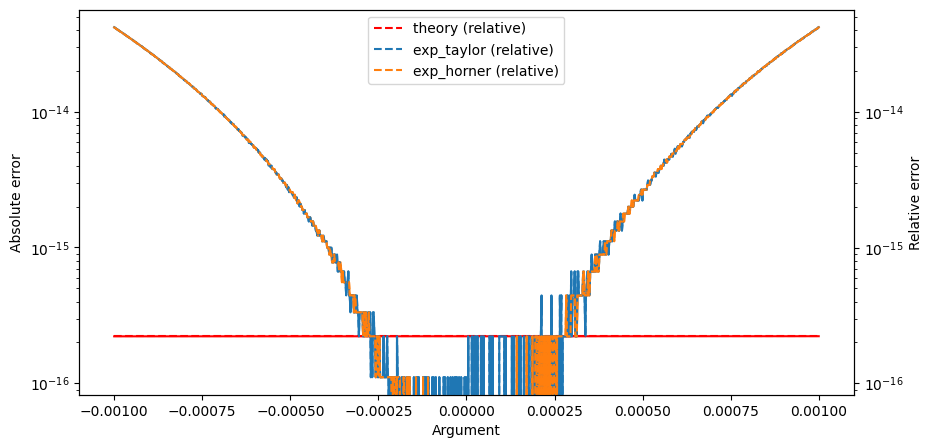

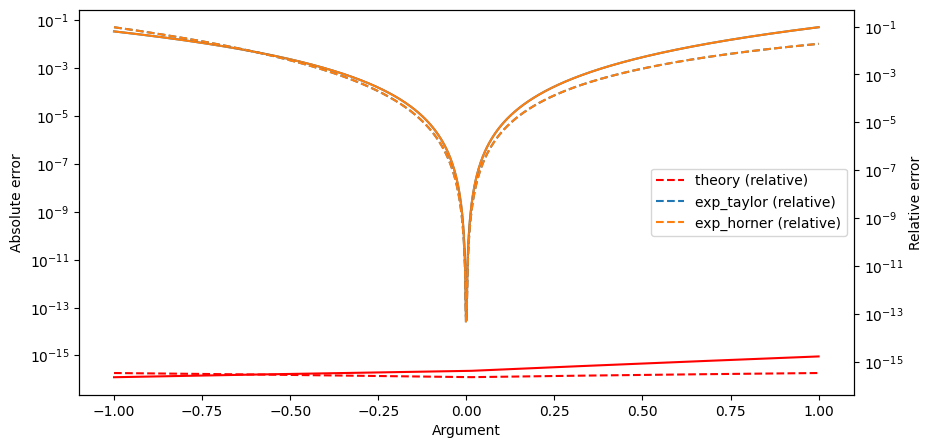

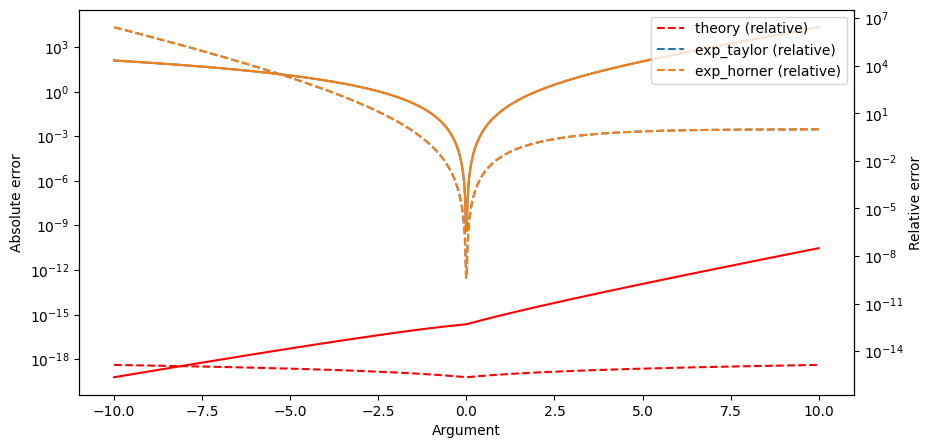

In [31]:
def exp_taylor(x, N=None):
    """N-ая частичная сумма ряда Тейлора для экспоненты."""
    acc = 1 # k-ая частичная сумму. Начинаем с k=0.
    xk = 1 # Степени x^k.
    inv_fact = 1 # 1/k!.
    for k in range(1, N+1):
        xk = xk*x
        inv_fact /= k
        acc += xk*inv_fact
    return acc

def exp_horner(x, N=None):
    """N-ая частичная сумма ряда Тейлора для экспоненты методом Горнера."""
    if N<=0: return 1 # Избегаем деления на ноль.
    acc = 1 # Выражение во вложенных скобках в схеме Горнера
    for k in range(N, 0, -1):
        acc = acc/k*x + 1
    return acc

def make_exp_test(fns, args={}, xmin=-1, xmax=1):
    """Проводит тест приближения fn показательной функции."""
    x = np.linspace(xmin, xmax, 1000)
    standard = np.exp(x)
    
    theoretical_relative_error = (np.abs(x)/2+1)*np.finfo(float).eps
    theoretical_absolute_error = theoretical_relative_error * standard
    
    fig, ax1 = plt.subplots(1,1,figsize=(10,5))
    ax2 = plt.twinx(ax1)
    ax1.set_xlabel("Argument")
    ax1.set_ylabel("Absolute error")
    ax2.set_ylabel("Relative error")

    ax1.semilogy(x, theoretical_absolute_error, '-r')
    
    line, = ax2.semilogy(x, theoretical_relative_error, '--r')
    line.set_label("theory (relative)")
    
    for fn in fns:
        subject = fn(x, **args)
        absolute_error = np.abs(standard-subject)
        relative_error = absolute_error/standard
    
        ax1.semilogy(x, absolute_error, '-')
    
        line,  = ax2.semilogy(x, relative_error, '--')
        line.set_label("{} (relative)".format(fn.__name__))
    
    
    plt.legend()
    plt.show()
    
    
make_exp_test([exp_taylor, exp_horner], args={"N": 3}, xmin=-0.001, xmax=0.001)    
make_exp_test([exp_taylor, exp_horner], args={"N": 3}, xmin=-1, xmax=1)
make_exp_test([exp_taylor, exp_horner], args={"N": 3}, xmin=-10, xmax=10)

Ясно, что 4-x слагаемых слишком мало, чтобы хорошо приблизить ряд. Попробуем взять больше.

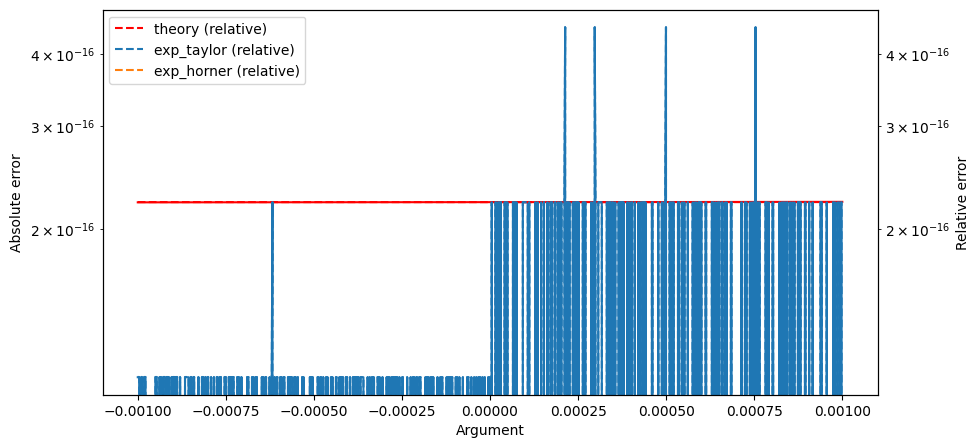

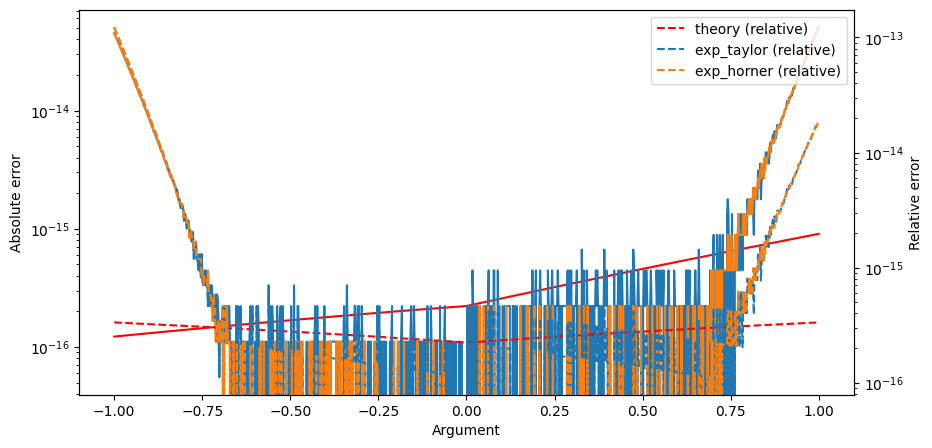

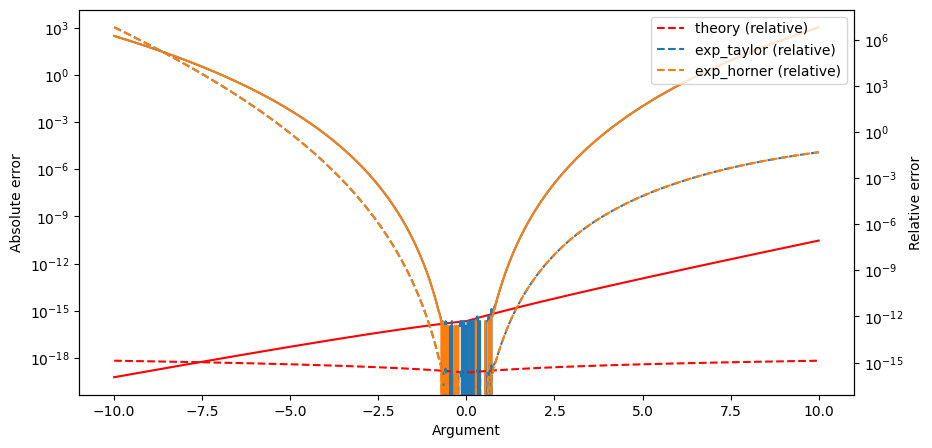

In [32]:
make_exp_test([exp_taylor, exp_horner], args={"N": 15}, xmin=-0.001, xmax=0.001)    
make_exp_test([exp_taylor, exp_horner], args={"N": 15}, xmin=-1, xmax=1)
make_exp_test([exp_taylor, exp_horner], args={"N": 15}, xmin=-10, xmax=10)

Точность приближения растет с увеличением числа слагаемых, однако даже для умеренно больших аргументов ни одного верного знака в ответе не получается. Посмотрим, как погрешность изменяется в зависимости от числа слагаемых.

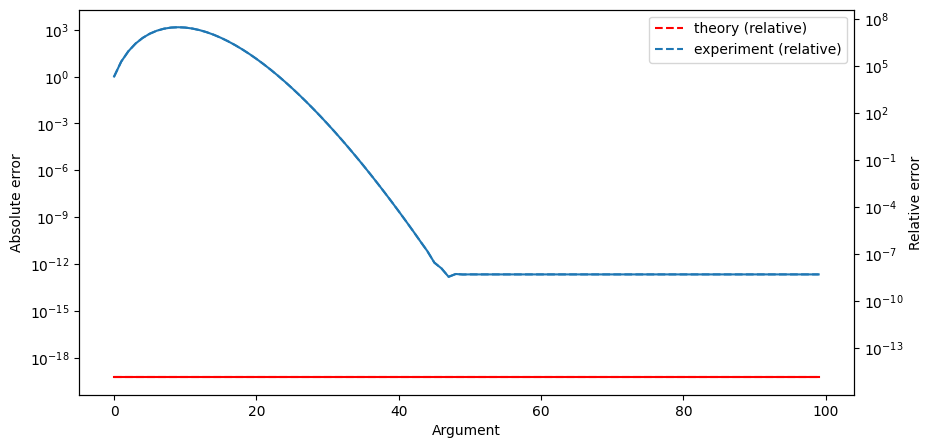

In [33]:
def cum_exp_taylor(x, N=None):
    """Вычисляет все частичные суммы ряда Тейлора для экспоненты по N-ую включительно."""
    acc = np.empty(N+1, dtype=float)
    acc[0] = 1 # k-ая частичная сумму. Начинаем с k=0.
    xk = 1 # Степени x^k.
    inv_fact = 1 # 1/k!.
    for k in range(1, N+1):
        xk = xk*x
        inv_fact /= k
        acc[k] = acc[k-1]+xk*inv_fact
    return acc

x = -10
standard = np.exp(x)
theoretical_relative_error = (np.abs(x)/2+1)*np.finfo(float).eps
theoretical_absolute_error = theoretical_relative_error * standard
Ns = np.arange(100)

partial_sums = cum_exp_taylor(x, N=Ns[-1])
absolute_error = np.abs(partial_sums-standard)
relative_error = absolute_error/standard

fig, ax1 = plt.subplots(1,1,figsize=(10,5))
ax2 = plt.twinx(ax1)
ax1.set_xlabel("Argument")
ax1.set_ylabel("Absolute error")
ax2.set_ylabel("Relative error")

ax1.semilogy(Ns, Ns*0+theoretical_absolute_error, '-r')

line, = ax2.semilogy(Ns, Ns*0+theoretical_relative_error, '--r')
line.set_label("theory (relative)")

ax1.semilogy(Ns, absolute_error, '-')
    
line,  = ax2.semilogy(Ns, relative_error, '--')
line.set_label("experiment (relative)")

plt.legend()
plt.show()

Оказывается, что даже суммируя очень большое число слагаемых, мы не можем достигнуть максимальной точности. 

# Задания

### 7. Относительная ошибка приближения частичной суммой ряда Тейлора показательной функцией много больше для отрицательных аргументов. Объясните причину этого. Воспользуйтесь свойствами показательной функции, чтобы выравнить точность вычислений при положительных и отрицательных аргументах.

Ошибку можно объяснить, рассмотрев погрешность для рассматриваемого ряда:

$$\bigg|\Delta\dfrac{x_n}{n!}\bigg| = \Delta\dfrac{|x^n|}{n!} = n\cdot\dfrac{|x^n|}{n!}\cdot |\delta x| = |\delta x|\dfrac{|x^n|}{(n-1)!}$$


$$\Delta S_N \leq \sum_{n=0}^N |\delta x|\dfrac{|x^n|}{(n-1)!} \leq |\delta x\cdot x| \sum_{n=0}^{N-1} \dfrac{|x^n|}{n!}\leq e^{|x|}\cdot |\Delta x|$$


$$|\delta S_N| = \dfrac{|\Delta x|e^{|x|}}{e^x} = |\Delta x| \cdot e^{|x|-x}$$


Из оценки погрешности видно, что при положительных значениях аргумента - экспонента не вносит вклад в погрешность (т.к. ее агрумент равен нулю), а при отрицательных значениях агрумент экспоненты равен $-2x$, что вносит сильный вклад в эволюцию ошибки - экспоненциально растущая ошибка при больших значениях аргумента.

### 8. Почему абсолютная погрешность мала при аргументах близких к нулю? Как именно погрешность зависит от аргумента? 

$$Arg\to0\quad\Rightarrow\quad\exp(Arg)\to 1\quad\Rightarrow\quad\Delta x = \frac{\epsilon}{2}\cdot x \to 0 \quad\Rightarrow\quad|\delta S_N| \to 0 $$

### 9. Абсолютная погрешность приближения функции частичной суммой ряда равна остатку этого ряда.

* Оцените остаток ряда Тейлора для экспоненты и найдите число слагаемых, необходимое для вычисления экспоненты с наперед заданной точностью.

* Проведите эксперимент и убедитесь, что предсказанная вами точность отличается от фактической не более чем на порядок.

$$\bigg|\sum^{+\infty}_{n=N}\dfrac{x^n}{n!}\bigg|\leq \dfrac{1}{N!}\sum^{+\infty}_{n=N}\dfrac{|x^n|}{N!} = x \bigg(N!\cdot N^N\cdot \bigg(1-\dfrac{|x|}{N}\bigg)\bigg)^{-1}$$


24


C:\Temp\ipykernel_13700\2981959762.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  acc[0] = x / (1-np.abs(x))
C:\Temp\ipykernel_13700\2981959762.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  acc[k] = err / np.abs(1 - np.abs(x) / k) / nk


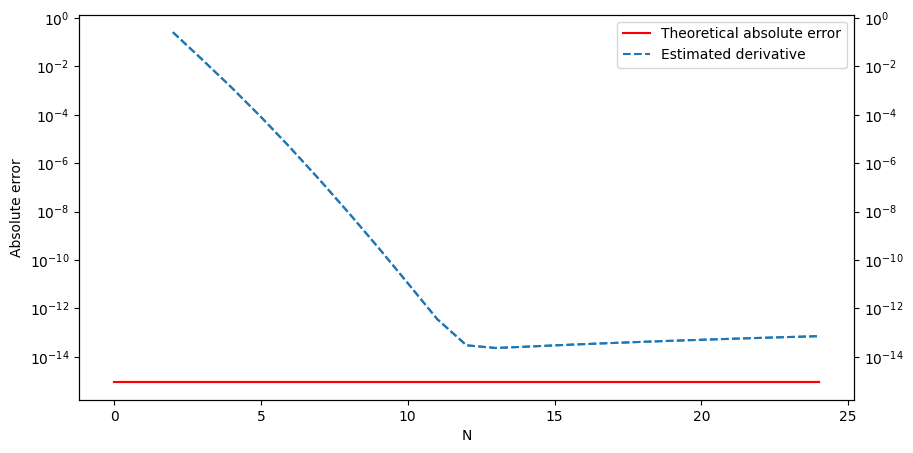

2.220446049250313e-16
Количество слагаемых (точность: 1e-15 ): N = 6


In [35]:
def exp_evaluation(x, N=None):
  err = 1
  nk = 1
  acc = np.ones(N+1, dtype=float)
  acc[0] = x / (1-np.abs(x))
  for k in range(1, N+1):
    err = err * x
    acc[k] = err / np.abs(1 - np.abs(x) / k) / nk 
    for i in range (1, k+1):
      acc[k] = acc[k] / k
    nk = nk + 1
  return acc

eps0=np.finfo(np.double).eps

x = 1
rx = round(x)
standard = np.exp(x)
theoretical_relative_error = (np.abs(x)/2+1)*np.finfo(float).eps
theoretical_absolute_error = theoretical_relative_error * standard
Ns = np.arange(15 + 10*np.abs(rx))

print(Ns[-1])
summ_err=Ns*(Ns+3)*x*eps0/2

partial_sums = cum_exp_taylor(x, N=Ns[-1])
absolute_error = np.abs(partial_sums-standard)
evaluation_absolute_error = exp_evaluation(x, N = Ns[-1])

relative_error = absolute_error/standard

fig, ax1 = plt.subplots(1,1,figsize=(10,5))
ax2 = plt.twinx(ax1)
ax1.set_xlabel("N")
ax1.set_ylabel("Absolute error")
ax1.semilogy(Ns, Ns*0+theoretical_absolute_error, '-r')
line, = ax2.semilogy(Ns, Ns*0+theoretical_absolute_error, '-r')
line.set_label("Theoretical absolute error")
ax1.semilogy(Ns,  evaluation_absolute_error + summ_err, '--')
line, = ax2.semilogy(Ns,  evaluation_absolute_error + summ_err, '--')
line.set_label("Estimated derivative")
plt.legend()
plt.show()

def how_n_to_complete_exp(eps, x):
  N=1
  eps_now=N*(N+3)*x*eps0/2 + exp_evaluation(x, N)[-1]
  num=1
  hvost=exp_evaluation(x, num)[-1]
  summ_eps=num*(num+3)*x*eps0/2
  while hvost>=summ_eps:
    num=num+1
    hvost=exp_evaluation(x, num)[-1]
    summ_eps=num*(num+3)*x*eps0/2
  max_eps=summ_eps+hvost
  if eps>max_eps:
    while eps_now>=eps:
        N=N+1
        eps_now=N*(N+3)*x*eps0/2 + exp_evaluation(x, N)[-1]
    return N
  else:
     return 'Eps is too small'

current_eps=1e-15
print(eps0)
print('Количество слагаемых (точность:', current_eps, '): N =' ,how_n_to_complete_exp(current_eps,0.01))

### 10. Ошибка вычисления через частичную сумму складывается из ошибки отбрасывание остатка ряда и ошибки вычисления умножений и сложений. При увеличинии числа слагаемых первая ошибка уменьшается, но вторая растет. Для произвольного x оцените число слагаемых, при которых точность вычисления показательной функции максимальна.

Выше уже получили оценку остатка ряда:

$$\bigg|\sum^{+\infty}_{n=N}\dfrac{x^n}{n!}\bigg|\leq \dfrac{|x|^N}{N!}\sum^{+\infty}_{n=0}\dfrac{|x^n|}{N^n} = \dfrac{|x|^{N+1}}{N!(N-|x|)} $$

Оценим погрешность от суммирования и возведения в степень при вычислении ряда: $$\sum^N_{n=1} \dfrac{x^n}{n!}$$

Погрешность от возведения в степень и сложения: 
$$ \sum^N_{n=1} n\cdot  \delta x = \dfrac{N(N+1) \delta x}{2}$$

Также прибавим погрешность от деления на $n!$: $N \delta x$

Тогда получим полную погрешность:

$$\Delta e^{x} = \dfrac{N(N+3)\cdot x \cdot \delta x }{2} + \dfrac{|x|^{N+1}}{N!(N-|x|)}$$

### 11. Схема Горнера дает несколько меньшую погрешность, чем суммирование одночленов. Почему?

Найдем погрешность схемы Горнера, которая складывается из множителей $\bigg(1+\dfrac{x}{n}\bigg)$ с единичной погрешностью
$$\Delta x \dfrac{3}{n}\quad\Rightarrow\quad\sum_{n=1}^{N}\bigg[\Delta x \dfrac{3}{n} \bigg]\leq 3N \Delta x$$

### 12. Можете предложить лучший способ вычисления показательной функции?

Из полученных результатов, можно предположить, что суммирование методом Кэхэна в порядке убывания будет оптимальным вариантом для подсчета экспоненты. 